# <span style="color:green">Geolocalisation  -  Notebook 2.2 Modelling genomic data - SAMPLING SITE</span>

## <span style="color:green">0. Load packages and data stored as pkl</span>

In [218]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, average_precision_score, f1_score

df = pd.read_csv('./pkl/df_c2_filtPos80filtSamp70_meanval.csv.gz', index_col=0) # df generated in Notebook 2.1
geo = pd.read_csv("../../../Documents/Postgrau_DSML/Geolocalisation/data/Sample_localisation_extended.csv")# Data with geolocalisation

## <span style="color:green">1. Modelling </span>
#### <span style="color:green">Define X and y variables</span>

In [219]:
# Set seed
import random
random.seed(1)

names = df.axes[0].tolist() # Names of samples
geo = geo.reset_index().set_index('ExtractID').loc[names].reset_index().set_index('index') # Extract geo rows that are in names

# Convert to numpy because I will need it later (for the leave-one-out approach)
y = geo.iloc[:,1:2].to_numpy() # For Sampling Site
X = df.reset_index(drop = True).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# To make sure that dimensions are ok
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(276, 288274)
(70, 288274)
276
70


<span style="color:green">The category **Sampling Site** is more convoluted and so it is anticipated that a less straight-forward implementation will be needed.</span>

<span style="color:green"> Based on the results obtained when modeling genomic data to infer the chimpanzee's subspecies, we will test three different classifiers:</span>

<span style="color:green">1. Random Forest</span>

<span style="color:green">2. Nearest neighbor</span>

<span style="color:green">3. Support vector machine</span>



### <span style="color:green">1.1 Random forest</span>
#### <span style="color:green">1.1.1 The simplest model (default parameters)</span>
<span style="color:green">Let's start by the most simple model, random forest classifier without default parameters.</span>

In [232]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Train + predict
rf_clf = RandomForestClassifier(random_state = 1, oob_score = True, n_jobs = -1)
rf_y_pred = rf_clf.fit(X_train, y_train.ravel()).predict(X_test)

print("The rf_clf model has an accuracy of", rf_clf.score(X_train,y_train), "in the data it has been trained.")

print("Balanced accuracy:", balanced_accuracy_score(y_test, rf_y_pred)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, rf_y_pred, average = 'micro')) 

The rf_clf model has an accuracy of 1.0 in the data it has been trained.
Balanced accuracy: 0.5554187192118227
F1-score (micro) on the prediction: 0.6428571428571429


<span style="color:green">Not bad for a default model. Let's plot the confusion matrix of the predictions vs true sampling sites.</span>

Text(0.5, 1.0, 'Confusion matrix Random Forest Classifier (default params)')

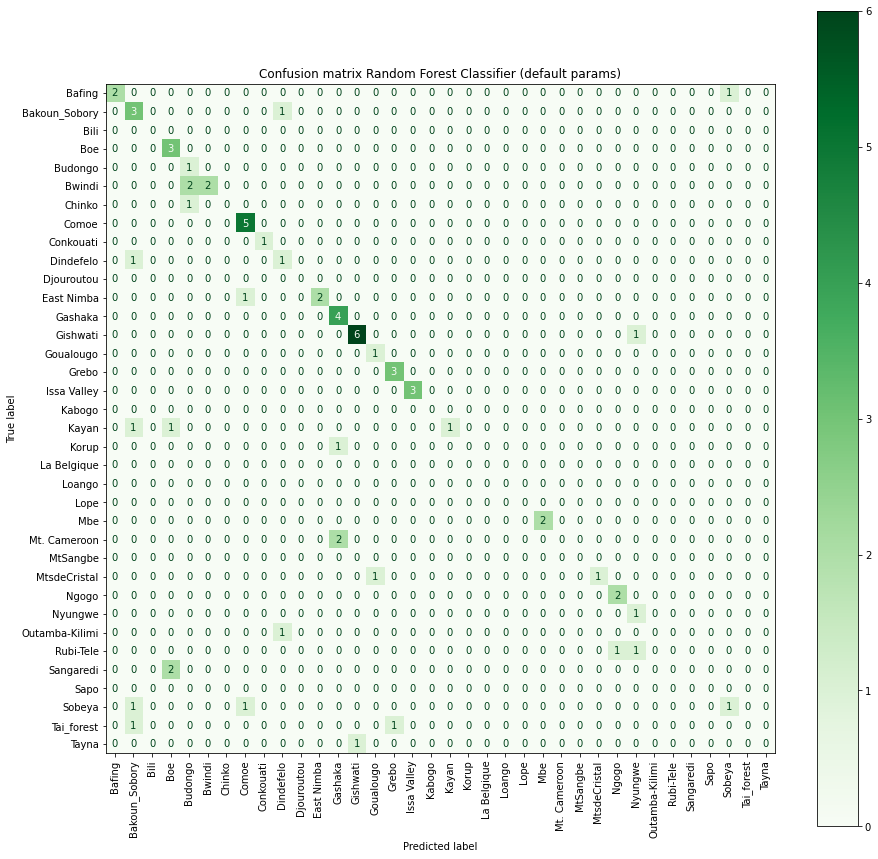

In [229]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, rf_y_pred, labels=rf_clf.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Random Forest Classifier (default params)")

<span style="color:green">The Random Forest classifier shows a relatively good performance. Let's try to improve the parameters for the classifier. For that, we will use **GridSearchCV**, which is an approach for parameter searching that exhaustively considers all parameter combinations. To avoid inflating the performance in the predictions, GridSearchCV will be applied to the training set only.</span>

#### <span style="color:green">1.1.2 Parameter optimisation</span>

In [223]:
from sklearn.model_selection import GridSearchCV

RFC=RandomForestClassifier(random_state=1, oob_score = True, n_jobs = -1)
print("Step 1: classifier loaded")

param_grid = {'n_estimators' : [50,100,200,300], ## Default is 100,
              'max_features': ['auto', 'sqrt', 'log2'],  
              'criterion' : ['gini', 'entropy']}
print("Step 2: parameteres to test charged")

CV_RFC = GridSearchCV(estimator=RFC, param_grid=param_grid, scoring= "f1_micro", cv = 4)
print("Step 3: searching parameters over the estimator")

CV_RFC.fit(X_train,y_train.ravel())
print("Step 4: Fitting X and y over the parameters")

Step 1: classifier loaded
Step 2: parameteres to test charged
Step 3: searching parameters over the estimator


/Users/paulaestellercucala/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Step 4: Fitting X and y over the parameters


In [225]:
CV_RFC.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 300}

In [226]:
# Train + predict
rf_clf = RandomForestClassifier(random_state = 1, oob_score = True, n_jobs = -1, 
                                criterion = 'gini', max_features = 'auto', n_estimators = 300)

rf_y_pred = rf_clf.fit(X_train, y_train.ravel()).predict(X_test)

print("The rf_clf model has an accuracy of", rf_clf.score(X_train,y_train), "in the data it has been trained.")

print("Balanced accuracy:", balanced_accuracy_score(y_test, rf_y_pred)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, rf_y_pred, average = 'micro')) 

The rf_clf model has an accuracy of 1.0 in the data it has been trained.
Balanced accuracy: 0.5562397372742199
F1-score (micro) on the prediction: 0.6142857142857143


<span style="color:green">The accuracy is not improved a lot after using *optimal* parameters.</span>

Text(0.5, 1.0, 'Confusion matrix Random Forest Classifier (improved params)')

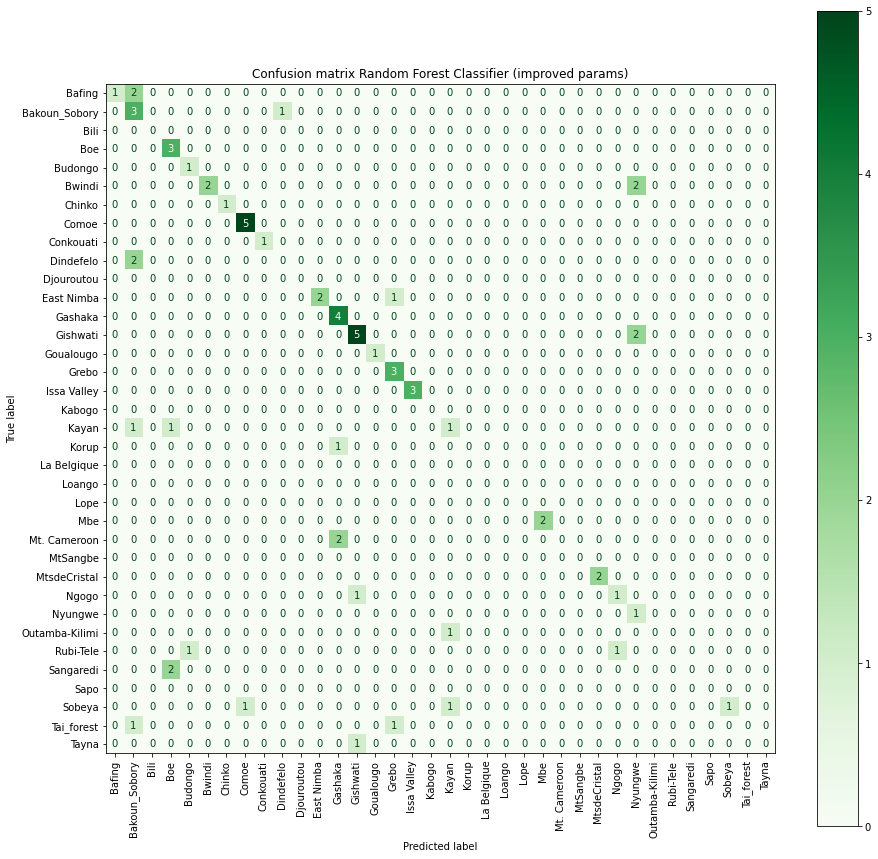

In [227]:
cm = confusion_matrix(y_test, rf_y_pred, labels=rf_clf.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Random Forest Classifier (optimised params)")

#### <span style="color:green">1.1.3 Leave-one-out cross-validation</span>

<span style="color:green">Given the nature of this project, the dataset of study contains a relatively low number of samples. Because of this, when applying the standard train vs test methodology, since the number of instances in each of the data groups becomes even smaller, the power to train a classifier that is able to predict the location of a particular sample becomes more difficult. In this cases, the **leave-one-out cross-validation** approach becomes handy, as it allows for each sample to be used as a test set while the remaining samples form the training set. This method is less biased and tends to not overesetimate perfomance of the model eventhough it is computationally expensive.</span>

In [246]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

y_true, y_pred = list(),list()
count = 0 # Internal testing
for train_index, test_index in loo.split(X):
   # count = count + 1 # Internal testing
    
    # split data
    X_train_iter, X_test_iter = X[train_index], X[test_index]
    y_train_iter, y_test_iter = y[train_index], y[test_index]
    

    # fit and evaluate model
    rf_y_pred = RandomForestClassifier(random_state = 1,n_jobs = -1,criterion = 'gini', max_features = 'auto', 
                                       n_estimators = 300).fit(X_train_iter, y_train_iter.ravel()).predict(X_test_iter)   
    # store values
    y_true.append(y_test_iter[0])
    y_pred.append(rf_y_pred[0])
    
   # print(count, y_test_iter[0], rf_y_pred[0]) # Internal testing

print("Balanced accuracy:", balanced_accuracy_score(y_true,y_pred)) 
print("F1-score (micro) on the prediction:", f1_score(y_true,y_pred, average = 'micro'))

1 ['Bafing'] Bakoun_Sobory
2 ['Bafing'] Bafing
3 ['Comoe'] Comoe
4 ['Comoe'] Comoe
5 ['Comoe'] Comoe
6 ['Comoe'] Comoe
7 ['Comoe'] Comoe
8 ['Comoe'] Comoe
9 ['Comoe'] Comoe
10 ['Comoe'] Comoe
11 ['Comoe'] Comoe
12 ['Comoe'] Comoe
13 ['Comoe'] Comoe
14 ['Comoe'] Comoe
15 ['Comoe'] Comoe
16 ['Comoe'] Comoe
17 ['Comoe'] Comoe
18 ['Bafing'] Kayan
19 ['Comoe'] Comoe
20 ['Conkouati'] Conkouati
21 ['Conkouati'] Conkouati
22 ['Conkouati'] Conkouati
23 ['Conkouati'] Conkouati
24 ['Conkouati'] Conkouati
25 ['Conkouati'] Conkouati
26 ['Conkouati'] Loango
27 ['Bafing'] Bakoun_Sobory
28 ['Conkouati'] Conkouati
29 ['Dindefelo'] Bakoun_Sobory
30 ['Dindefelo'] Bakoun_Sobory
31 ['Dindefelo'] Boe
32 ['Dindefelo'] Bakoun_Sobory
33 ['Dindefelo'] Boe
34 ['Dindefelo'] Boe
35 ['Bafing'] Bakoun_Sobory
36 ['Dindefelo'] Kayan
37 ['Dindefelo'] Bafing
38 ['Dindefelo'] Bakoun_Sobory
39 ['Dindefelo'] Bakoun_Sobory
40 ['Dindefelo'] Bakoun_Sobory
41 ['Dindefelo'] Kayan
42 ['La Belgique'] MtsdeCristal
43 ['Djouroutou'

334 ['Bwindi'] Bwindi
335 ['Bwindi'] Nyungwe
336 ['Mt. Cameroon'] Gashaka
337 ['Mt. Cameroon'] Gashaka
338 ['Mt. Cameroon'] Gashaka
339 ['Bafing'] Bafing
340 ['Chinko'] Chinko
341 ['Chinko'] Rubi-Tele
342 ['Chinko'] Chinko
343 ['Chinko'] Rubi-Tele
344 ['Chinko'] Chinko
345 ['Chinko'] Budongo
346 ['Comoe'] Comoe
Balanced accuracy: 0.4817523891053303
F1-score (micro) on the prediction: 0.6560693641618497


<span style="color:green">The accuracy is not improved a lot after implementing the leave-one-out cross-validation, though it seems that the samples that are not correctly identified are placed near their true sampling site.</span>

Text(0.5, 1.0, 'Confusion matrix Random Forest Classifier (improved params)')

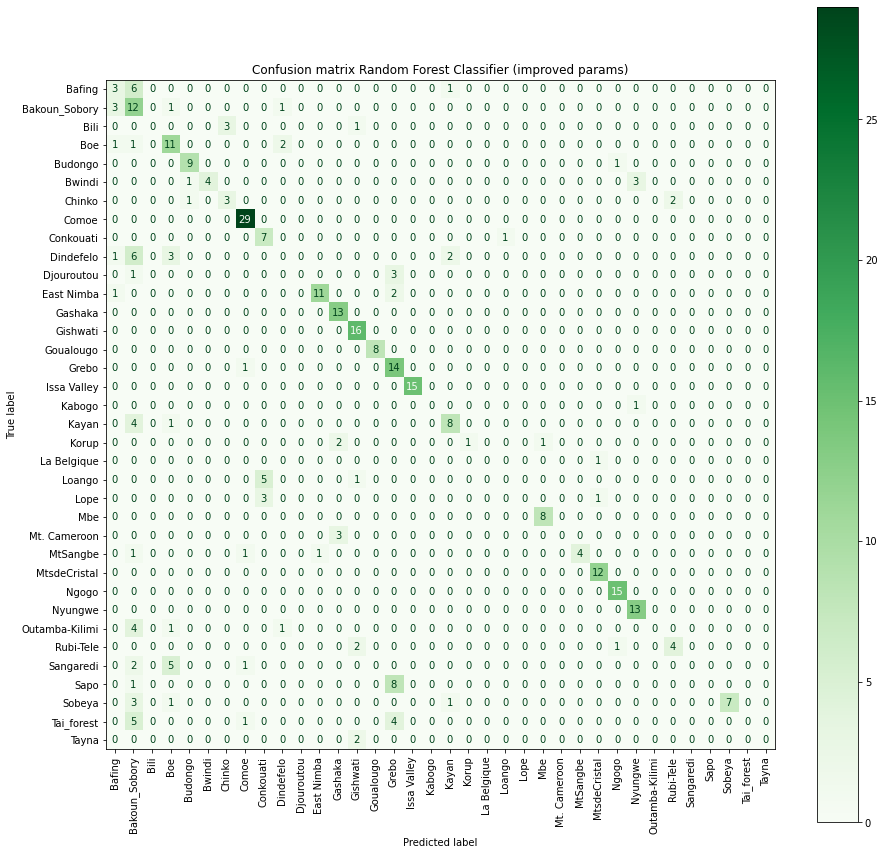

In [247]:
cm = confusion_matrix(y_true, y_pred, labels=rf_clf.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Random Forest Classifier (LOO CV)")

In [248]:
f1_score(y_true,y_pred, average = 'micro')

0.6560693641618497

### <span style="color:green">1.2 Nearest Neighbors</span>
#### <span style="color:green">1.2.1 The simplest model (default parameters)</span>

In [287]:
from sklearn.neighbors import KNeighborsClassifier

# Train + predict
nn_clf_def = KNeighborsClassifier(n_jobs = -1)
nn_y_pred_def = nn_clf_def.fit(X_train, y_train.ravel()).predict(X_test)

print("The nn_clf_def model has an accuracy of", nn_clf_def.score(X_train,y_train), "in the data it has been trained.")
print("Balanced accuracy:", balanced_accuracy_score(y_test, nn_y_pred_def)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, nn_y_pred_def, average = 'micro')) 

The nn_clf_def model has an accuracy of 0.75 in the data it has been trained.
Balanced accuracy: 0.46756978653530373
F1-score (micro) on the prediction: 0.4714285714285714


/Users/paulaestellercucala/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Text(0.5, 1.0, 'Confusion matrix Nearest Neighbor Classifier (default params)')

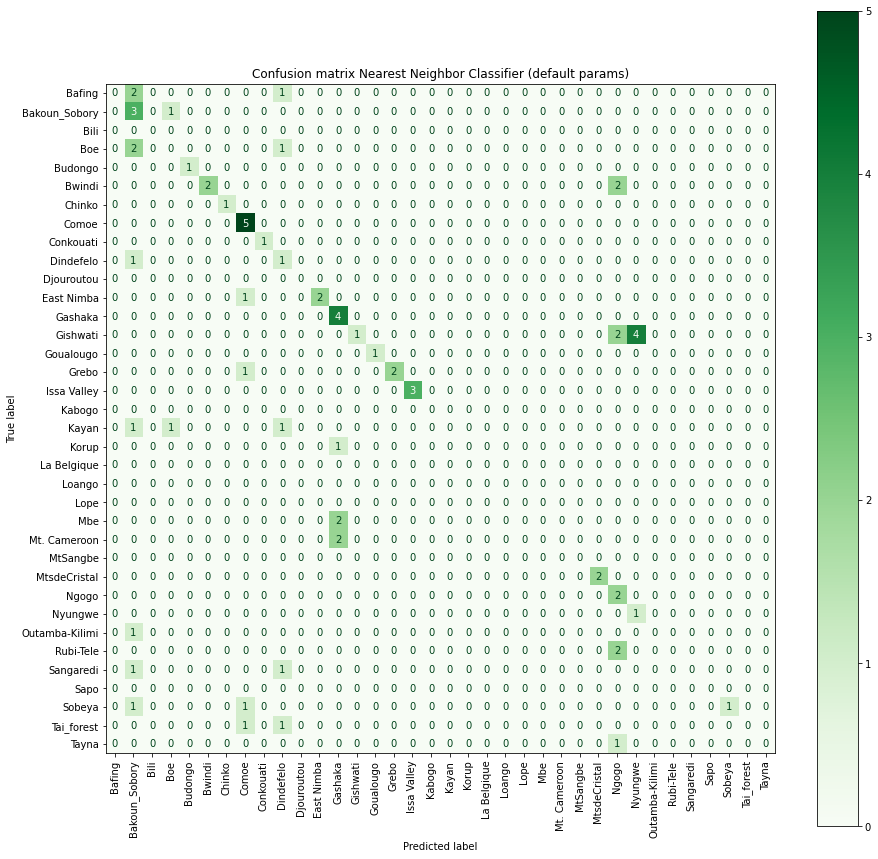

In [288]:
cm = confusion_matrix(y_test, nn_y_pred_def, labels=nn_clf_def.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn_clf_def.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Nearest Neighbor Classifier (default params)")

#### <span style="color:green">1.2.2 Parameter optimisation</span>

In [282]:
NN = KNeighborsClassifier(n_jobs = -1)
print("Step 1: classifier loaded")

param_grid = {'n_neighbors' : [1,5,10,15], ## Default is 5,
              'weights': ['uniform', 'distance'],  
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
print("Step 2: parameteres to test charged")

CV_NN = GridSearchCV(estimator=NN, param_grid=param_grid, scoring= "f1_micro", cv = 4)
print("Step 3: searching parameters over the estimator")

CV_NN.fit(X_train,y_train.ravel())
print("Step 4: Fitting X and y over the parameters")

Step 1: classifier loaded
Step 2: parameteres to test charged
Step 3: searching parameters over the estimator


/Users/paulaestellercucala/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Step 4: Fitting X and y over the parameters


In [283]:
CV_NN.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}

In [289]:
# Train + predict
nn_clf_opt = KNeighborsClassifier(n_jobs = -1, n_neighbors = 1,
                              algorithm = 'auto', weights = 'uniform')

nn_y_pred_opt = nn_clf_opt.fit(X_train, y_train.ravel()).predict(X_test)

print("The nn_clf_opt model has an accuracy of", nn_clf_opt.score(X_train,y_train), "in the data it has been trained.")

print("Balanced accuracy:", balanced_accuracy_score(y_test, nn_y_pred_opt)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, nn_y_pred_opt, average = 'micro')) 

The nn_clf_opt model has an accuracy of 1.0 in the data it has been trained.
Balanced accuracy: 0.5870279146141215
F1-score (micro) on the prediction: 0.6142857142857143


/Users/paulaestellercucala/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Text(0.5, 1.0, 'Confusion matrix Nearest Neighbor Classifier (optimised params)')

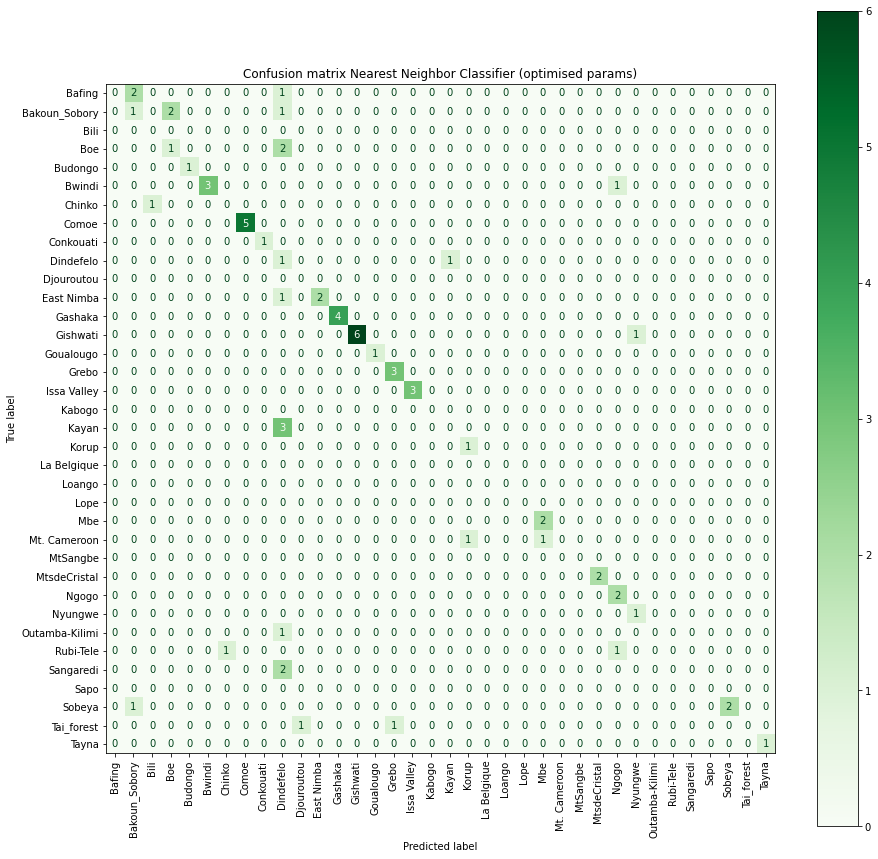

In [290]:
cm = confusion_matrix(y_test, nn_y_pred_opt, labels=nn_clf_opt.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn_clf_opt.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Nearest Neighbor Classifier (optimised params)")

#### <span style="color:green">1.2.3 Leave-one-out cross-validation</span>

In [297]:
loo = LeaveOneOut()

y_true, nn_y_pred_loo = list(),list()
count = 0 # Internal testing
for train_index, test_index in loo.split(X):
   # count = count + 1 # Internal testing
    
    # split data
    X_train_iter, X_test_iter = X[train_index], X[test_index]
    y_train_iter, y_test_iter = y[train_index], y[test_index]
    

    # fit and evaluate model
    # Train + predict
    nn_y_pred_loo_iter = KNeighborsClassifier(n_jobs = -1, n_neighbors = 1,
                              algorithm = 'auto', weights = 'uniform').fit(X_train_iter, y_train_iter.ravel()).predict(X_test_iter)   

    
    # store values
    y_true.append(y_test_iter[0])
    nn_y_pred_loo.append(nn_y_pred_loo_iter[0])
    
   # print(count, y_test_iter[0], nn_y_pred_loo_iter[0]) # Internal testing

print("Balanced accuracy:", balanced_accuracy_score(y_true,nn_y_pred_loo)) 
print("F1-score (micro) on the prediction:", f1_score(y_true,nn_y_pred_loo, average = 'micro'))

Balanced accuracy: 0.5800306123835536
F1-score (micro) on the prediction: 0.6994219653179191


In [299]:
nn_clf_def.classes_

array(['Bafing', 'Bakoun_Sobory', 'Bili', 'Boe', 'Budongo', 'Bwindi',
       'Chinko', 'Comoe', 'Conkouati', 'Dindefelo', 'Djouroutou',
       'East Nimba', 'Gashaka', 'Gishwati', 'Goualougo', 'Grebo',
       'Issa Valley', 'Kabogo', 'Kayan', 'Korup', 'La Belgique', 'Loango',
       'Lope', 'Mbe', 'Mt. Cameroon', 'MtSangbe', 'MtsdeCristal', 'Ngogo',
       'Nyungwe', 'Outamba-Kilimi', 'Rubi-Tele', 'Sangaredi', 'Sapo',
       'Sobeya', 'Tai_forest', 'Tayna'], dtype=object)

In [303]:
len(nn_y_pred_loo)

346

Text(0.5, 1.0, 'Confusion matrix Nearest Neighbor Classifier (LOO CV)')

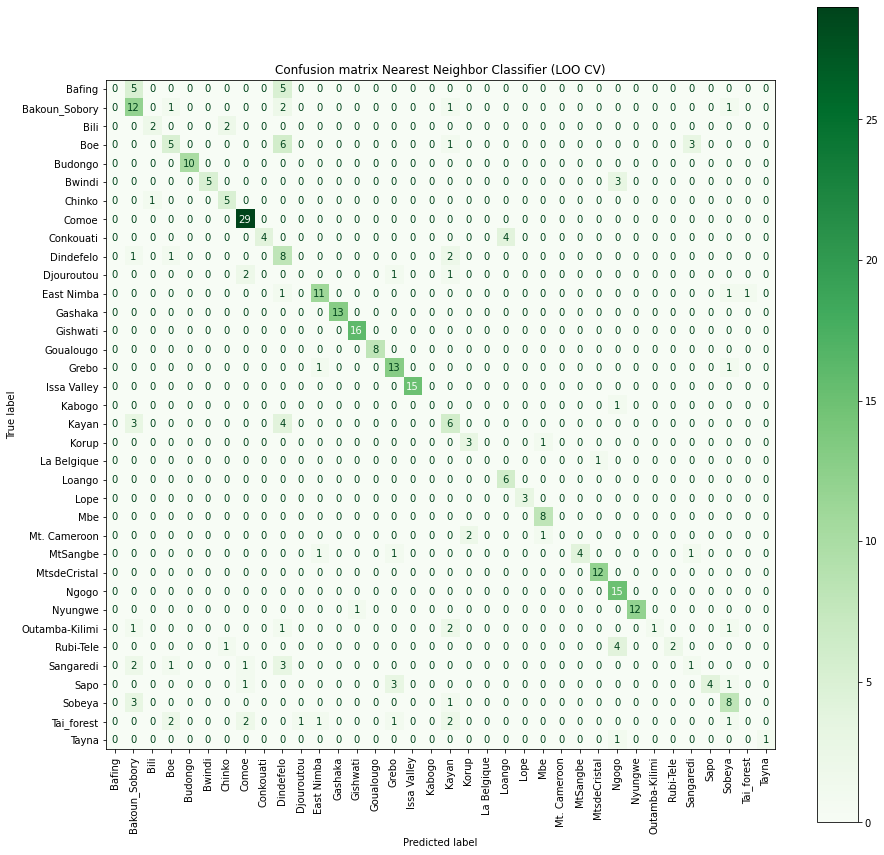

In [305]:
cm = confusion_matrix(y_true, nn_y_pred_loo,labels=nn_clf_def.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn_clf_def.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Nearest Neighbor Classifier (LOO CV)")

### <span style="color:green">1.3 Support vector machine</span>
#### <span style="color:green">1.3.1 The simplest model (default parameters)</span>

In [306]:
from sklearn.svm import LinearSVC

# Train + predict
svm_clf_def = LinearSVC(random_state=1)
svm_y_pred_def = svm_clf_def.fit(X_train, y_train.ravel()).predict(X_test)

print("The svm_clf model has an accuracy of", svm_clf_def.score(X_train,y_train), "in the data it has been trained.")

print("Balanced accuracy:", balanced_accuracy_score(y_test, svm_y_pred_def)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, svm_y_pred_def, average = 'micro')) 

The svm_clf model has an accuracy of 1.0 in the data it has been trained.
Balanced accuracy: 0.807471264367816
F1-score (micro) on the prediction: 0.8285714285714286


/Users/paulaestellercucala/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Text(0.5, 1.0, 'Confusion matrix Support Vector Machine (default params)')

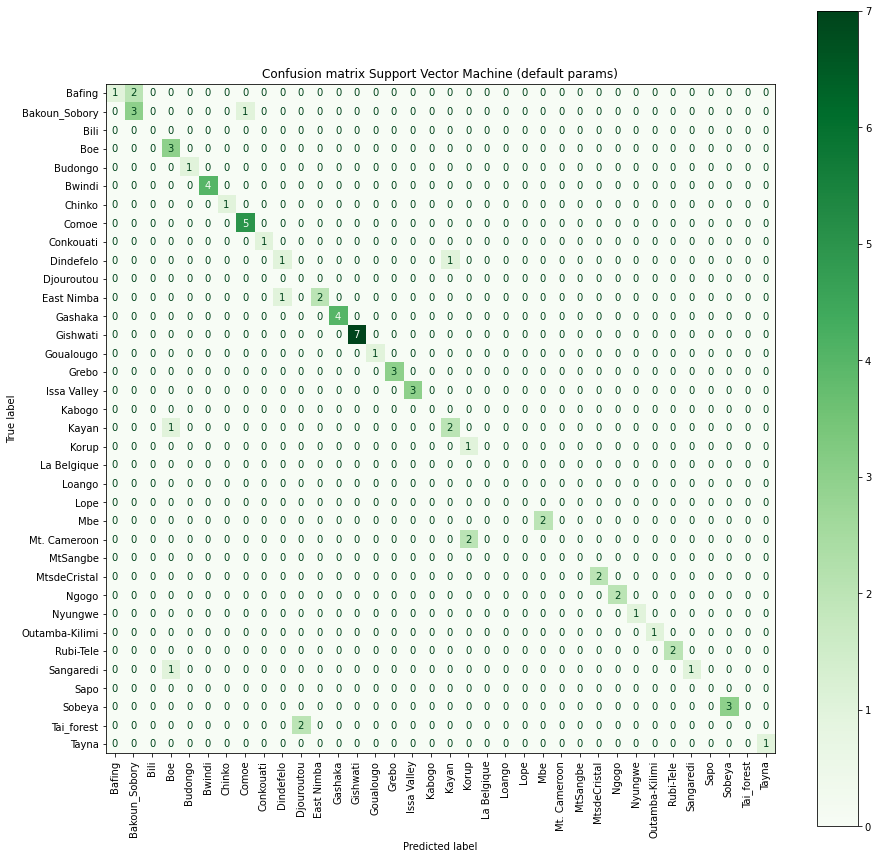

In [309]:
cm = confusion_matrix(y_test, svm_y_pred_def, labels=svm_clf_def.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_clf_def.classes_)

fig,ax = plt.subplots(figsize=(15,15))

cmp.plot(xticks_rotation = 'vertical', colorbar=True, cmap = "Greens", ax=ax)
cmp.ax_.set_title("Confusion matrix Support Vector Machine (default params)")

#### <span style="color:green">1.3.2 Parameter optimisation</span>

In [ ]:
SVC = LinearSVC(random_state = 1)
print("Step 1: classifier loaded")

param_grid = {
    #'C': [1, 10, 100, 1000, 10000], # Default is C=1.0
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], # Default is loss='squared_hinge'
              'tol':[0.001,0.0001]} # Default is tol=0.0001

print("Step 2: parameteres to test charged")

CV_SVC = GridSearchCV(estimator=SVC, param_grid=param_grid, scoring= "f1_micro", cv = 4)
print("Step 3: searching parameters over the estimator")

CV_SVC.fit(X_train,y_train.ravel())
print("Step 4: Fitting X and y over the parameters")

In [313]:
CV_SVC.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [289]:
# Train + predict
svm_clf_opt = KNeighborsClassifier(n_jobs = -1, n_neighbors = 1,
                              algorithm = 'auto', weights = 'uniform')

svm_y_pred_opt = nn_clf_opt.fit(X_train, y_train.ravel()).predict(X_test)

print("The nn_clf_opt model has an accuracy of", svm_clf_opt.score(X_train,y_train), "in the data it has been trained.")

print("Balanced accuracy:", balanced_accuracy_score(y_test, svm_y_pred_opt)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, svm_y_pred_opt, average = 'micro')) 

The nn_clf_opt model has an accuracy of 1.0 in the data it has been trained.
Balanced accuracy: 0.5870279146141215
F1-score (micro) on the prediction: 0.6142857142857143


/Users/paulaestellercucala/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [ ]:
# Train + predict
nn_clf_opt = KNeighborsClassifier(n_jobs = -1, n_neighbors = 1,
                              algorithm = 'auto', weights = 'uniform')

nn_y_pred_opt = nn_clf_opt.fit(X_train, y_train.ravel()).predict(X_test)

print("The nn_clf_opt model has an accuracy of", nn_clf_opt.score(X_train,y_train), "in the data it has been trained.")

print("Balanced accuracy:", balanced_accuracy_score(y_test, nn_y_pred_opt)) 
print("F1-score (micro) on the prediction:", f1_score(y_test, nn_y_pred_opt, average = 'micro')) 

#### <span style="color:green">1.3.3 Leave-one-out cross-validation</span>

# Other stuff

In [166]:
f1_score(y_true,y_pred, average = "micro")

0.6046511627906976

In [148]:
import pickle

open_file = open("./pkl/rf_params_accuracy_loo.pkl.gz", "wb")

In [101]:
import pickle

open_file = open("./pkl/rf_accuracy_loo.pkl.gz", "wb")
#pickle.dump(accuracy, open_file)